# Reverse time migration example on a 2D  acoustic model

In [1]:
# Add module path
import sys
import os

currloc = os.getcwd()

sys.path.append(currloc+'/../../devito/')
sys.path.append(currloc+'/../../examples/')
sys.path.append(currloc+'/../acoustic/')

In [2]:
from examples.containers import IShot, IGrid
import numpy as np
from examples.acoustic.Acoustic_codegen import Acoustic_cg
from devito import clear_cache

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import ndimage

/Volumes/Users/mloubout/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Dimensions on constant initailization

In [3]:
# Define geometry
dimensions = (201, 201, 70)
origin = (0., 0.)
spacing = (15., 15.)
spc_order = 4

# Load velocity model

In [4]:
# Read velocity
vp = 1e-3*np.fromfile(currloc+'/../data/marmousi3D/MarmousiVP.raw', dtype='float32', sep="")
print(np.shape(vp))
vp = vp.reshape(dimensions)
print(np.shape(vp))
vp = vp[101, :, :]
print(np.shape(vp))
dimensions = (201, 70)
truc = (vp <= (np.min(vp)+.01))
# Smooth velocity
smooth_vp = ndimage.gaussian_filter(vp, sigma=(3,3), order=0)

smooth_vp = np.max(vp)/np.max(smooth_vp)* smooth_vp
smooth_vp[truc] = vp[truc]
# Create models
model = IGrid()
model0 = IGrid()

model.create_model(origin, spacing, vp)
model0.create_model(origin, spacing, smooth_vp)

(2828070,)
(201, 201, 70)
(201, 70)


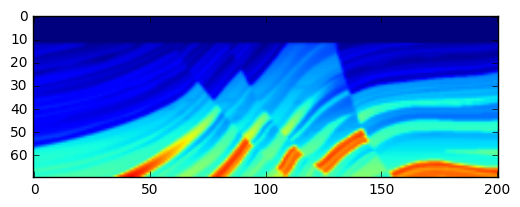

In [5]:
# True velocity
fig1 = plt.figure()
l = plt.imshow(np.transpose(vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

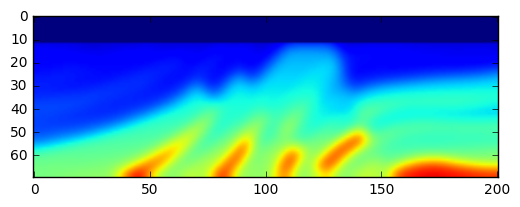

In [6]:
# Smooth velocity
fig2 = plt.figure()
l = plt.imshow(np.transpose(smooth_vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

# Acquisition geometry

In [7]:
# Source function
# Set up the source as Ricker wavelet for f0
def source(t, f0):
    r = (np.pi * f0 * (t - 1./f0))

    return (1-2.*r**2)*np.exp(-r**2)
# Define seismic data.
data = IShot()

f0 = .010
dt = model.get_critical_dt()
t0 = 0.0
tn = 1500
nt = int(1+(tn-t0)/dt)

time_series = source(np.linspace(t0, tn, nt), f0)
location = (origin[0] + dimensions[0] * spacing[0] * 0.5,
            origin[1] + 2 * spacing[1])
data.set_source(time_series, dt, location)

receiver_coords = np.zeros((101, 2))
receiver_coords[:, 0] = np.linspace(2 * spacing[0],
                                    origin[0] + (dimensions[0] - 2) * spacing[0],
                                    num=101)
receiver_coords[:, 1] = origin[1] + 2 * spacing[1]
data.set_receiver_pos(receiver_coords)
data.set_shape(nt, 101)

# Shot record

In [8]:
Acoustic = Acoustic_cg(model, data, t_order=2, s_order=4)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7d5fab1a95c7d595408f3e6ff47fbb5b9ee3cc48.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/11a6a5c5a4fc5d3bd123886f8886409fbe27a94a.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/5a5f7486d88fb2de57e91b1590808927b16215fa.cpp


In [9]:
print("Applying Forward")
rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/47c4acf153332175e14e56762f115d46c4a68f0b.cpp


Applying Forward


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/91ee40533876143e54817a6fe1c559b065ab4a47.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/57299c1e6f7dc04a7617d80535fd7df0448a99fb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6838693080e85b587944e6893246aa91da52192e.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/c984af061210a93104a1f0b17a32ffd6b20a6540.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.864871 s (41 MCells/s)


Stencil: 1.937500 OI, 1.36 GFlops/s (time: 0.862102 s)


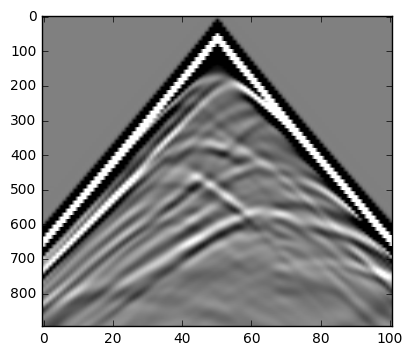

In [10]:
# Shot record
fig3 = plt.figure()
l = plt.imshow(rec, vmin=-1, vmax=1, aspect=.1, cmap=cm.gray)
plt.show()

# RTM

In [17]:
nsrc = 101
sources = np.linspace(2 * spacing[0],origin[0] + (dimensions[0] - 2) * spacing[0],num=101)
grad = np.zeros(dimensions)
grad = np.pad(grad, [(40, 40),(40,40)],'edge')

for i in range(50,51):
    print("Starting source : " + str(i+1) + "over " + str(nsrc))
    location = (sources[i] ,origin[1] + 2 * spacing[1])
    data.set_source(time_series, dt, location)
    # True data
    Acoustic = Acoustic_cg(model, data, t_order=2, s_order=4)
    rec, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)
    # Smooth data and wavefield
    Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)
    # gradient
    grad = Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/82e6ef88ee9aa61fa157e22da084870644b7eafe.cpp


Starting source : 51over 101


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/25e184faba9a64a6bc0653af5708f09871d8bafb.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/3dfd84eb269573d74c8e7395d0816c5742852e76.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6d4ab1b70388f98167bab963c52b50c678bcd375.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/343ef436b1820c685a7ae175bd85d78b78308cec.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a93aea8e579c75c1ca21516246d714111cc60ae4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/9b7b92249a7f8d16590887ec0b17d6aa4ba31d99.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1e0f24156e241f3488184152062dbc3ac194c1db.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.833697 s (43 MCells/s)


Stencil: 1.937500 OI, 1.41 GFlops/s (time: 0.831796 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/54f738c7bf92cb46d49e3d6451a1b206e2de05e0.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/a7b8650ddc1817dbe35dedb568c48dd6c60daf52.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/1b75f5762e94a3355b7b1b0eb719b0237d1e4644.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/e2f0794dd0c1d84572af82a237ffe692d99874b8.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6e9528ce62c620b48402c8aed03f614c6a4254e2.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/6cbfaa8a021850af73c44ff2af282b21748f065d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/7406641058130265dd4d92f175e2c78225444107.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/32569ffd7f789874beeeddbb57f46ee9017d62c4.cpp


Shape: (281 x 150) - Cache Blocking: None


Time: 0.834110 s (43 MCells/s)


Stencil: 1.937500 OI, 1.40 GFlops/s (time: 0.832360 s)


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/31c0673fa02cf5eefea482a75c4138dbd8975e61.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/8a573b9511cca0d7f72e27e6711277a9c1e996e6.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/28cc1cb64fb7356f7128ac41bc3307eb195e23f4.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b814b4b00d7a6cf02a922c7294bc002e6ea1ac05.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/fe1a0de5f0d2b7c493edf32358979f1a021e259d.cpp


GNUCompiler: Compiling /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-502/b9659d70486ef6f4253e465d29374c3aa4b9cacc.cpp


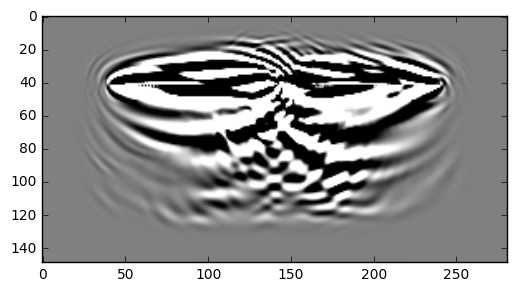

In [18]:
# Smooth velocity
fig4 = plt.figure()
l = plt.imshow(np.diff(np.transpose(grad),1,0), vmin=-10, vmax=10, aspect=1, cmap=cm.gray)
plt.show()

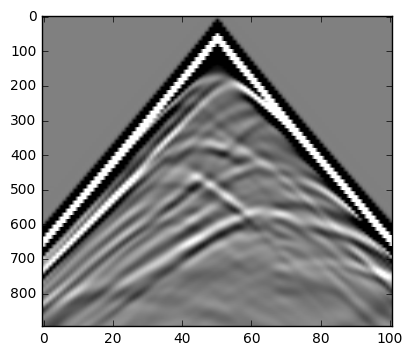

In [19]:
# Shot record
fig5 = plt.figure()
l = plt.imshow(rec, vmin=-1, vmax=1, aspect=.1, cmap=cm.gray)
plt.show()

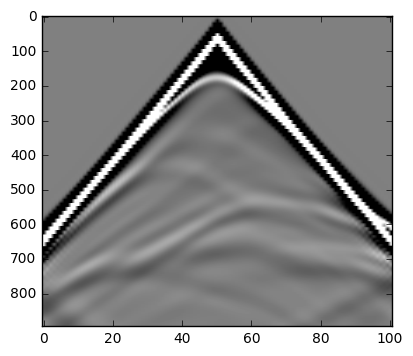

In [20]:
# Shot record
fig6 = plt.figure()
l = plt.imshow(rec0, vmin=-1, vmax=1, aspect=.1, cmap=cm.gray)
plt.show()

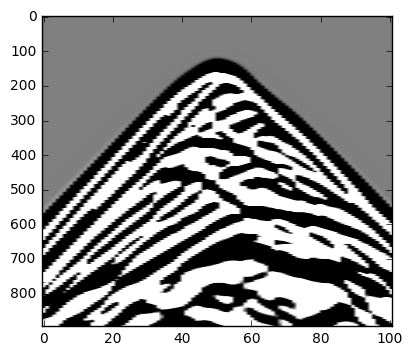

In [21]:
fig7 = plt.figure()
l = plt.imshow(rec0 - rec, vmin=-.01, vmax=.01, aspect=.1, cmap=cm.gray)
plt.show()